# Kaggle competition: Predicting House Prices 202003

In [94]:
pip install pandasql

In [95]:
pip install shap

In [0]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from pydoc import help
import scipy.stats as stats
from scipy.stats.stats import pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats.stats import kendalltau
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandasql as ps
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
import shap
from xgboost import XGBRegressor
import math
from scipy.stats import skew

In [0]:
#conda install -c conda-forge scikit-learn

In [0]:
#conda update -n base -c defaults conda

In [0]:
def correlated_variables(data,obj_variable,min_abs_corr=0.6):
    """
    Generates a DataFrame with the correlations and variables that are higher than "min_corr" for variable selection.
    data: DataFrame. Correlation matrix only for numeric variables and including objective variable.
    min_abs_corr: int. Minimum absolute correlation that will be selected as high correlated
    obj_variable: string. Name of the objective variable for the model
    """
    high_corr = pd.DataFrame(columns=['Variable1','Variable2','Corr_V1&V2','Corr_V1&Obj','Corr_V2&Obj'])
    k=1
    obj_var_pos = data.columns.get_loc(obj_variable)
    for i in range(0,len(data)):
        for j in range(k,len(data)):
            if(np.absolute(data.iloc[i,j])>=min_abs_corr and j!=obj_var_pos):
                a = data.index[i]
                b = data.columns[j]
                c = data.iloc[i,j]
                d = data.iloc[i,obj_var_pos]
                e = data.iloc[j,obj_var_pos]
                high_corr = high_corr.append(pd.DataFrame([[a,b,c,d,e]],columns=high_corr.columns))
        k+=1
    return high_corr.sort_values('Corr_V1&V2',ascending=False)

In [0]:
def null_info(df):
    null_count = df.isna().sum().to_frame()
    null_count.columns = ['#_NA'] 
    null_count['%'] = null_count*100/len(df)
    #null_count[null_count['%']>30].sort_values('%',ascending=False)
    df_dtypes = df.dtypes.to_frame()
    df_dtypes.columns = ['data_type']
    return null_count.merge(df_dtypes,how='left',left_on=null_count.index,right_on=df_dtypes.index).sort_values('%',ascending=False)


In [0]:
#Generate 'Empty' category for categorical variables and fill with 0 numerical ones
def fill_missing_values(data):
    """
    Fill missing values with category 'Empty' for categorical variables and 0 for numerical
    Data: DataFrame. Contains the data that will be analyzed
    """
    df1 = data.copy()
    for i in df1:
        if df1[i].dtypes == 'object': 
            #print('Transforming column: ',i,'\n')
            df1[i].fillna('Empty',inplace=True)
        else:
            df1[i].fillna(0,inplace=True)
    return df1

In [0]:
def integrate_dummies(data,key):
    """Generates data set ready for applying a machine learning algorithm: sepparates the object variables, gets the dummie 
    variables and returns a data frame with all the features.
    data: pandas data frame, only contains the features that will be used for the machine learning algorithm
    key: pandas series, column that contains primary key of the dataset
    """
    is_object = data.dtypes==object
    numeric_features = [i for i in is_object.index if is_object[i]==False]
    object_features = [i for i in is_object.index if is_object[i]==True]
    dummies = pd.get_dummies(data[object_features],drop_first=True)
    dummies['key'] = key
    #dummies['key']=df_1.rut_deudor.astype(str)+df_1.rut_cliente.astype(str)
    numeric_df = data.loc[:,numeric_features]
    numeric_df['key'] = key
    return pd.merge(left=numeric_df,right=dummies, how='inner', on='key').drop('key',axis=1)

In [0]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Returns the mean absolute percentage error
    y_true: 1d array. Real values of "y"
    y_pred: 1d array. Predicted values of "y"
    """
    #y_true, y_pred = check_array(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def pearson_filtering(data,obj_variable,max_pvalue=0.05,min_abs_pearson=0.5):
    """
    Returns DataFrame with the pearson correlation and p-values for numerical variables of "data" with a higher correlation than "threshold" with the "obj_variable"
    data: Data Frame containing numerical and categorical variables as well as the objective variable
    max_pvalue: float/int. Maximum pvalue for numeric variables correlation
    min_abs_pearson: float/int. Minimum absolute pearson correlation between the regressor variables and objective variable ("obj_variable")
    obj_variable: string. Name of the objective variable within "data"
    """
    data_corr = data.loc[:,data.dtypes!='object'].corr()
    selected_numerical = data_corr[data_corr[obj_variable].abs()>min_abs_pearson][obj_variable]
    try:
        selected_numerical.drop([obj_variable],inplace=True)
    except (KeyError):
        pass

    #Calculate P-values and filtering significant variables (<5%)
    pearson_stats = [pearsonr(data[i].to_numpy(),data[obj_variable]) for i in data[selected_numerical.index]]
    result = pd.DataFrame(pearson_stats,columns=['Corr_Coef','P-value'],index=selected_numerical.index)
    result['abs_corr'] = result['Corr_Coef'].abs()
    return result[result['P-value']<max_pvalue].sort_values('abs_corr',ascending=False).drop('abs_corr',axis=1)

In [0]:
def cross_plot(data, barra, variable, categorias, size=(10,7), titulo = None, order=1):
    """
    Generates double axis plot with lines and bars
    data: DataFrame. With data for the plot.
    barra: String. Name of the column of "data" that will be represented as bars.
    variable: String. Name of the column of "data" that will be represented as a line.
    categorias: String. Name of the column of "data" that will be used as the x-axis categories.
    titulo: String. Title of the graph.
    order: Int. 1 means "categorias" will be ordered.
    """
    fig, ax1 = plt.subplots(figsize=size)
    ax2 = ax1.twinx()
    if order==1:
        data = data.sort_values(barra).reset_index(drop=True)
    data[barra].plot(kind='bar', color='b', ax=ax1, label=barra)
    try:
        for v in variable:
            data[v].plot(kind='line', marker='d', ax=ax2, label=v)
    except:
        data[variable].plot(kind='line',color='r', marker='d', ax=ax2, label=variable)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ticks = data[categorias]
    plt.xticks(np.arange(ticks.unique().shape[0]),ticks)
    plt.xticks(rotation=60)
    
    n_cat = data.shape[0]
    max_height = data[variable].max()
    min_height = data[variable].min()
    plt.xlim(-0.5,n_cat-0.5)
    plt.ylim(min_height*0.95,max_height*1.05)
    
    plt.title(titulo)
    ax1.set_xlabel(categorias)
    ax1.set_ylabel(barra)
    ax2.set_ylabel(variable)
    plt.legend()

In [0]:
path = 'https://raw.githubusercontent.com/tgrasty/house_prices/master/train.csv'

In [0]:
df = pd.read_csv(path)

In [0]:
datasets = {'1.original':df}

In [109]:
datasets['0.0_test_original'] = pd.read_csv('https://raw.githubusercontent.com/tgrasty/house_prices/master/test.csv')
datasets['0.0_test_original'].shape

(1459, 80)

In [110]:
df.shape

(1460, 81)

In [0]:
pd.set_option('display.max_rows', 100)

In [112]:
# Check data types
sample = df.head().transpose()
types = df.dtypes.to_frame()
types.merge(sample,how='left',left_on=types.index,right_on=sample.index).head()

,key_0,0_x,0_y,1,2,3,4
0,Id,int64,1,2,3,4,5
1,MSSubClass,int64,60,20,60,70,60
2,MSZoning,object,RL,RL,RL,RL,RL
3,LotFrontage,float64,65,80,68,60,84
4,LotArea,int64,8450,9600,11250,9550,14260


In [0]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

In [114]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] <0.01
normal = pd.DataFrame(df[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())


False


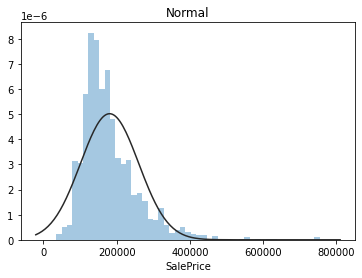

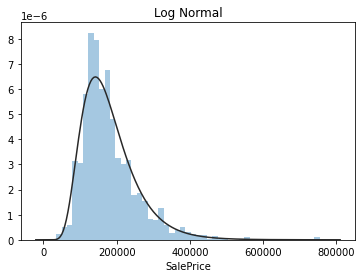

In [115]:
import seaborn as sns
y = df['SalePrice']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

### Data Cleansing


In [156]:
df_nulls = null_info(df)
df_nulls.head()
#df_nulls[df_nulls['%']>0].sort_values('%',ascending=False)

,key_0,#_NA,%,data_type
72,PoolQC,1453,99.520548,object
74,MiscFeature,1406,96.301370,object
6,Alley,1369,93.767123,object
73,Fence,1179,80.753425,object
57,FireplaceQu,690,47.260274,object


In [0]:
features = pd.concat([df.drop('SalePrice',axis=1),datasets['0.0_test_original']]).reset_index(drop=True)
df1 = fill_missing_values(features)

In [159]:
df1_nulls = null_info(df1)
df1_nulls[df1_nulls['%']>0].sort_values('%',ascending=False)

,key_0,#_NA,%,data_type


#### Correction of data types

In [139]:
df1['CentralAir'].unique()

array(['Y', 'N'], dtype=object)

In [0]:
#CentralAir -> transform to binary
df1['CentralAir'] = df1['CentralAir'].map(lambda x: 1 if x=='Y' else 0)

In [0]:
#Correct current numeric variables that represent categories: transform to string
to_string = ['MSSubClass','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']
new_categorical = df1[to_string].astype(str)
df1.drop(to_string,axis=1,inplace=True)
df1 = pd.concat([df1,new_categorical],axis=1)

In [142]:
df1.MSSubClass.dtypes

dtype('O')

###  Variable Generation

In [0]:
df1['TotalArea'] = df1.PoolArea+df1.LotArea+df1.GrLivArea+df1.GarageArea

In [0]:
#features_subset = df.loc[:,['Neighborhood','TotalArea','OveralQual','HeatingQC','CentralAir','SaleCondition']]
df1['TotalLivingArea'] = df1['1stFlrSF']+df1['2ndFlrSF']

In [0]:
df1['YrBltAndRemod']=df1['YearBuilt']+df1['YearRemodAdd']
df1['TotalSF']=df1['TotalBsmtSF'] + df1['1stFlrSF'] + df1['2ndFlrSF']
 
df1['Total_sqr_footage'] = (df1['BsmtFinSF1'] + df1['BsmtFinSF2'] +
                                 df1['1stFlrSF'] + df1['2ndFlrSF'])
 
df1['Total_Bathrooms'] = (df1['FullBath'] + (0.5 * df1['HalfBath']) +
                               df1['BsmtFullBath'] + (0.5 * df1['BsmtHalfBath']))
 
df1['Total_porch_sf'] = (df1['OpenPorchSF'] + df1['3SsnPorch'] +
                              df1['EnclosedPorch'] + df1['ScreenPorch'] +
                              df1['WoodDeckSF'])
df1['haspool'] = df1['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df1['has2ndfloor'] = df1['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df1['hasgarage'] = df1['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df1['hasbsmt'] = df1['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df1['hasfireplace'] = df1['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [0]:
datasets['2.cleaned + new variables'] = df1

In [147]:
datasets.keys()

dict_keys(['1.original', '0.0_test_original', '2.cleaned + new variables'])

### Standardization

In [120]:
df1.shape

(2919, 83)

In [63]:
# numerical_variables = [i for i in df1 if df1[i].dtypes!=object and i!="Id"]
# standard_df1 = (df1[numerical_variables]-df1[numerical_variables].mean())/df1[numerical_variables].std()
# df2 = df1.drop(numerical_variables,axis=1)
# df2 = pd.concat([df2,standard_df1],axis=1)
# df2.head()
# #scaler = StandardScaler() 
# #data_scaled = scaler.fit_transform(df1)

,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,...,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,TotalArea,TotalLivingArea,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,1,RL,Pave,Empty,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,SBrkr,Gd,Typ,Empty,Attchd,RFn,TA,TA,Y,Empty,Empty,...,-0.507197,0.528944,0.581046,-0.292975,-0.934005,-0.443002,0.268244,-0.773728,1.207172,-0.10118,0.413476,1.087148,-0.249676,0.781232,1.232388,0.169898,-0.207663,0.986680,-0.924153,0.306987,0.349304,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.108098,-0.177185,0.424747,0.022999,0.563921,1.584495,-0.762145,-0.066873,1.154503,0.239178,0.166755,-1.027264
1,2,RL,Pave,Empty,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,Empty,Empty,...,2.187904,-0.566919,1.178053,-0.292975,-0.629176,0.477381,0.268244,0.261030,-0.784891,-0.10118,-0.471810,-0.818789,3.821854,0.781232,-0.756191,0.169898,-0.207663,-0.287709,0.623525,0.306987,-0.058981,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,0.854568,-0.101416,-0.464714,-0.029167,0.332621,0.348157,0.718906,-0.066873,-0.865877,0.239178,0.166755,0.973126
2,3,RL,Pave,Empty,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Empty,Empty,...,-0.507197,0.338845,0.098173,-0.292975,-0.287950,-0.297917,0.268244,-0.610614,1.235163,-0.10118,0.563659,1.087148,-0.249676,0.781232,1.232388,0.169898,-0.207663,-0.287709,0.623525,0.306987,0.627680,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.248948,0.185123,0.575637,0.196886,0.374676,1.584495,-0.880880,-0.066873,1.154503,0.239178,0.166755,0.973126
3,4,RL,Pave,Empty,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,Empty,Empty,...,-0.507197,-0.566919,-0.494445,-0.292975,-0.046816,-0.669697,0.268244,-0.506118,0.978574,-0.10118,0.427309,1.087148,-0.249676,-1.027187,-0.756191,0.169898,-0.207663,0.349486,0.623525,1.618986,0.785426,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,0.464884,-0.028979,0.438644,-0.092511,-0.070839,-0.270012,0.775149,-0.066873,1.154503,0.239178,0.166755,0.973126
4,5,RL,Pave,Empty,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Empty,Empty,...,-0.507197,1.389978,0.469107,-0.292975,-0.160558,0.212148,0.268244,-0.037164,1.671364,-0.10118,1.377806,1.087148,-0.249676,0.781232,1.232388,1.385418,-0.207663,1.623875,0.623525,1.618986,1.685509,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.497782,0.635539,1.393624,0.988072,1.138228,1.584495,0.581425,-0.066873,1.154503,0.239178,0.166755,0.973126


In [0]:
# datasets['3.standardized'] = df2

In [65]:
datasets.keys()

dict_keys(['1.original', '0.0_test_original', '2.cleaned + new variables', '3.standardized'])

### Variable Selection

In [124]:
# df2.loc[:,df2.dtypes!='object'].shape

(2919, 35)

#### Filtering numerical variables: Pearson correlation

In [0]:
# selected_numerical = pearson_filtering(df2,'SalePrice',max_pvalue=0.05,min_abs_pearson=0.0)

In [67]:
# selected_numerical.head()

,Corr_Coef,P-value
Id,-0.739838,0.000000e+00
TotalSF,0.318439,8.694537e-70
TotalLivingArea,0.299542,1.395091e-61
GrLivArea,0.299150,2.034098e-61
OverallQual,0.295558,6.277394e-60


In [68]:
# #Check correlation
# a = pd.DataFrame(data=selected_numerical.index)
# b = pd.DataFrame([['SalePrice']],columns=a.columns)
# correlation = df2[a.append(b).iloc[:,0]].corr()
# correlation.head()

,Id,TotalSF,TotalLivingArea,GrLivArea,OverallQual,Total_sqr_footage,TotRmsAbvGrd,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,Total_Bathrooms,FullBath,hasfireplace,Fireplaces,MasVnrArea,TotalArea,LotArea,BsmtFinSF1,2ndFlrSF,Total_porch_sf,WoodDeckSF,HalfBath,OpenPorchSF,CentralAir,BsmtUnfSF,hasgarage,LotFrontage,BsmtFullBath,BedroomAbvGr,hasbsmt,EnclosedPorch,has2ndfloor,PoolArea,3SsnPorch,KitchenAbvGr,haspool,SalePrice
Id,1.000000,-0.030070,-0.025700,-0.029046,-0.029771,-0.023272,-0.029368,-0.025538,-0.011249,-0.009851,-0.008678,-0.010225,-0.009946,-0.036975,-0.035236,-0.026737,-0.041670,-0.040746,-0.017203,-0.022252,0.007774,-0.007056,-0.015358,0.009960,-0.014043,-0.014790,0.003071,0.001435,-0.000318,0.003074,-0.016235,0.021609,-0.004165,0.014332,-0.046538,-0.011702,0.020015,-0.739838
TotalSF,-0.030070,1.000000,0.872117,0.867157,0.665490,0.843881,0.657261,0.829380,0.551298,0.574006,0.793379,0.608814,0.576157,0.448329,0.471757,0.470492,0.379592,0.318138,0.431067,0.298512,0.390177,0.284668,0.244623,0.349634,0.199900,0.370793,0.166282,0.228335,0.218755,0.350625,0.254038,-0.049610,0.116011,0.122659,0.024988,0.052598,0.136396,0.318439
TotalLivingArea,-0.025700,0.872117,1.000000,0.995788,0.582296,0.789232,0.802765,0.449954,0.497429,0.491754,0.566361,0.604598,0.633523,0.446001,0.462164,0.407260,0.354018,0.285809,0.219058,0.656534,0.375010,0.253639,0.439232,0.343583,0.127950,0.231169,0.138766,0.184784,0.063945,0.513014,0.057858,-0.004744,0.472114,0.132839,0.006716,0.118015,0.144525,0.299542
GrLivArea,-0.029046,0.867157,0.995788,1.000000,0.575126,0.782124,0.808354,0.445710,0.488933,0.484547,0.562538,0.597469,0.630286,0.443361,0.459386,0.400088,0.352845,0.284519,0.211980,0.655085,0.375455,0.251017,0.433548,0.341907,0.123901,0.234388,0.130193,0.185659,0.059333,0.517058,0.058058,0.003274,0.469779,0.135441,0.006268,0.117502,0.147212,0.299150
OverallQual,-0.029771,0.665490,0.582296,0.575126,1.000000,0.544908,0.389761,0.549763,0.600743,0.565179,0.479152,0.546981,0.528483,0.435395,0.390753,0.426528,0.148936,0.100541,0.282150,0.245596,0.289857,0.255317,0.272668,0.298084,0.286890,0.275643,0.249250,0.132635,0.165060,0.073075,0.221701,-0.139256,0.125013,0.030740,0.018715,-0.159325,0.043219,0.295558


#### Filtering categorical variables: one hot encoding + Pearson correlation

In [0]:
selected_categorical = df2.loc[:,df2.dtypes == 'object']
#selected_categorical = pd.concat([selected_categorical,df2['SalePrice']],axis=1)

In [0]:
dummies = pd.get_dummies(selected_categorical.iloc[:,:],drop_first=True)

In [0]:
dummies = pd.concat([dummies,df2['SalePrice']],axis=1)

In [72]:
selected_categorical = pearson_filtering(dummies,'SalePrice',max_pvalue=0.05,min_abs_pearson=0.0)
selected_categorical

,Corr_Coef,P-value
ExterQual_TA,-0.211227,8.521787e-31
KitchenQual_TA,-0.206872,1.397670e-29
BsmtQual_Ex,0.183906,1.279215e-23
KitchenQual_Ex,0.180109,1.050043e-22
Foundation_PConc,0.177020,5.630075e-22
...,...,...
PavedDrive_P,-0.036609,4.796165e-02
YrBltAndRemod_19861987,0.036599,4.802300e-02
YrBltAndRemod_19761996,0.036390,4.931172e-02
BldgType_2fmCon,-0.036352,4.954915e-02


#### Filtering categorical variables: one hot encoding + linear regression coeficient´s significance

In [0]:
# Discarded because the coefficients depend on the amount of variables selected for the regression. It was not clear 
# whether it was correct to iteratively consider one variable at a time

In [0]:
#selected_categorical = df2.loc[:,df2.dtypes == 'object']
#dummies = pd.get_dummies(selected_categorical.iloc[:,:],drop_first=True)
#X2 = sm.add_constant(dummies)
#est = sm.OLS(df2['SalePrice'], X2)
#est2 = est.fit()
#results_as_html = est2.summary().tables[1].as_html()

#lm_results = pd.read_html(results_as_html, header=0, index_col=0)[0]
#lm_results
#lm_results.sort_values('P>|t|',ascending=True)

#### Filtering categorical variables: Kendall’s tau correlation

In [0]:
# Kendall´s correlation is discarded: because Kendall´s tau is designed for "ordinal association", 
# which is not the case here for categorical variables and also because it doesn´t measure the "magnitude" or "strength" of
# the association between the variables, but just whether they are in the same order or not.

In [0]:
#selected_categorical = df2.loc[:,df2.dtypes == 'object']
#selected_categorical = pd.concat([selected_categorical,df2['SalePrice']],axis=1)

# Null hypothesis for Kendall Tau test is absence of association
#kendall_corr = pd.DataFrame(index=selected_categorical.columns,columns=['kendall_corr','p-value'])
#j = 0
#for i in selected_categorical:
#    result = kendalltau(selected_categorical.loc[:,i],df2['SalePrice'])
#    kendall_corr.iloc[j,0] = result.correlation
#    kendall_corr.iloc[j,1] = result.pvalue
#    j+=1
#kendall_corr[kendall_corr['p-value']<0.05].sort_values('kendall_corr',ascending=False)

#### Filtering categorical variables: ANOVA

In [0]:
# ANOVA is discarded: the assumption of the distribution of the error is not met.

In [0]:
#selected_categorical = df1.loc[:,df2.dtypes=='object']
#selected_categorical = pd.concat([selected_categorical,df2['SalePrice']],axis=1)

#mod = ols('SalePrice ~ LotShape',data=selected_categorical).fit()

##To test normality of errors execute the following:
##import scipy.stats as stats
##stats.shapiro(mod.resid)

#aov_table = sm.stats.anova_lm(mod, typ=2)
#print(aov_table)

# Post hoc test
#mc = MultiComparison(df2['SalePrice'], df['LotShape'])
#mc_results = mc.tukeyhsd()
#print(mc_results)

### Correlation and Integration

In [79]:
# # Join selected variables

# #Generate list of unique original variable names
# a = list(set([i.split('_')[0] for i in selected_categorical.index]))

# b = [i for i in selected_numerical.index]
# c = ['SalePrice']
# total_selected = a+b+c
# len(total_selected)

81

In [80]:
datasets.keys()

dict_keys(['1.original', '0.0_test_original', '2.cleaned + new variables', '3.standardized'])

In [81]:
# a = pd.concat([datasets['3.standardized'][total_selected],df2['Id']],axis=1).reset_index(drop=True)
# df3 = pd.get_dummies(a,drop_first=True)
# df3.head()

,Id,TotalSF,TotalLivingArea,GrLivArea,OverallQual,Total_sqr_footage,TotRmsAbvGrd,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,Total_Bathrooms,FullBath,hasfireplace,Fireplaces,MasVnrArea,TotalArea,LotArea,BsmtFinSF1,2ndFlrSF,Total_porch_sf,WoodDeckSF,HalfBath,OpenPorchSF,CentralAir,BsmtUnfSF,hasgarage,LotFrontage,BsmtFullBath,BedroomAbvGr,hasbsmt,EnclosedPorch,has2ndfloor,PoolArea,3SsnPorch,KitchenAbvGr,haspool,SalePrice,Id,Exterior1st_AsphShn,...,LotShape_Reg,Alley_Grvl,Alley_Pave,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,MasVnrType_BrkFace,MasVnrType_Empty,MasVnrType_None,MasVnrType_Stone,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Empty,SaleType_New,SaleType_Oth,SaleType_WD
0,1,0.022999,0.424747,0.413476,0.646073,0.563921,0.986680,-0.443002,0.306987,0.349304,-0.773728,1.584495,0.781232,-1.027264,-0.924153,0.528944,-0.177185,-0.217841,0.581046,1.207172,-0.762145,-0.740634,1.232388,0.199972,0.268244,-0.934005,0.239178,0.216038,1.087148,0.169898,0.166755,-0.359539,1.154503,-0.063139,-0.103313,-0.207663,-0.066873,1.108098,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,2,-0.029167,-0.464714,-0.471810,-0.063174,0.332621,-0.287709,0.477381,0.306987,-0.058981,0.261030,0.348157,0.781232,0.973126,0.623525,-0.566919,-0.101416,-0.072032,1.178053,-0.784891,0.718906,1.614603,-0.756191,-0.702722,0.268244,-0.629176,0.239178,0.664045,-0.818789,0.169898,0.166755,-0.359539,-0.865877,-0.063139,-0.103313,-0.207663,-0.066873,0.854568,2,0,...,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2,3,0.196886,0.575637,0.563659,0.646073,0.374676,-0.287709,-0.297917,0.306987,0.627680,-0.610614,1.584495,0.781232,0.973126,0.623525,0.338845,0.185123,0.137173,0.098173,1.235163,-0.880880,-0.740634,1.232388,-0.081195,0.268244,-0.287950,0.239178,0.305639,1.087148,0.169898,0.166755,-0.359539,1.154503,-0.063139,-0.103313,-0.207663,-0.066873,1.248948,3,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,4,-0.092511,0.438644,0.427309,0.646073,-0.070839,0.349486,-0.669697,1.618986,0.785426,-0.506118,-0.270012,-1.027187,0.973126,0.623525,-0.566919,-0.028979,-0.078371,-0.494445,0.978574,0.775149,-0.740634,-0.756191,-0.184783,0.268244,-0.046816,0.239178,0.066702,1.087148,0.169898,0.166755,3.874303,1.154503,-0.063139,-0.103313,-0.207663,-0.066873,0.464884,4,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
4,5,0.988072,1.393624,1.377806,1.355319,1.138228,1.623875,0.212148,1.618986,1.685509,-0.037164,1.584495,0.781232,0.973126,0.623525,1.389978,0.635539,0.518814,0.469107,1.671364,0.581425,0.776834,1.232388,0.540332,0.268244,-0.160558,0.239178,0.783513,1.087148,1.385418,0.166755,-0.359539,1.154503,-0.063139,-0.103313,-0.207663,-0.066873,1.497782,5,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [82]:
# # Filter highly correlated variables
# correlation = df3.corr()
# pre_selection = correlated_variables(correlation,'SalePrice')
# pre_selection

,Variable1,Variable2,Corr_V1&V2,Corr_V1&Obj,Corr_V2&Obj
0,Id,Id,1.000000,-0.739838,-0.739838
0,YrBltAndRemod_18961950,GarageYrBlt_1896.0,1.000000,-0.015733,-0.015733
0,YrBltAndRemod_18932000,YearBuilt_1893,1.000000,0.040771,0.040771
0,YrBltAndRemod_18821986,YearBuilt_1882,1.000000,0.013476,0.013476
0,YrBltAndRemod_18751996,YearBuilt_1875,1.000000,0.000610,0.000610
...,...,...,...,...,...
0,RoofStyle_Gable,RoofStyle_Hip,-0.939469,-0.105885,0.104730
0,hasbsmt,BsmtExposure_Empty,-0.981018,0.064235,-0.064620
0,hasbsmt,BsmtFinType2_Empty,-0.993555,0.064235,-0.060030
0,hasgarage,GarageType_Empty,-0.996650,0.084306,-0.083268


In [83]:
# Filter strongly correlated variables

# pre_selection.reset_index(drop=True,inplace=True)
# result = []
# max_correlation = 0.4
# for i in pre_selection.index:
#     if pre_selection.loc[i,'Corr_V1&V2'] < max_correlation:
#         a = pre_selection.loc[i,'Corr_V1&Obj']
#         b = pre_selection.loc[i,'Corr_V2&Obj']
#         if a>=b:
#             result.append(pre_selection.loc[i,'Variable1'])
#         else:
#             result.append(pre_selection.loc[i,'Variable2'])
# result

['BsmtCond_TA',
 'Foundation_PConc',
 'Condition1_Norm',
 'GarageQual_TA',
 'LandContour_HLS',
 'ExterQual_Gd',
 'Foundation_PConc',
 'BsmtFinSF1',
 'OverallQual',
 'SaleType_New',
 'SaleCondition_Partial',
 'HouseStyle_2Story',
 'has2ndfloor',
 'MasVnrArea',
 'GarageQual_TA',
 'GarageType_Attchd',
 'RoofMatl_Tar&Grv',
 'SalePrice',
 'BsmtQual_Gd',
 'SaleCondition_Partial',
 'GarageCond_TA',
 'SaleType_New',
 'Foundation_PConc',
 'hasbsmt',
 '2ndFlrSF',
 'MasVnrType_BrkFace',
 'MSZoning_RL',
 'KitchenQual_Gd',
 'Electrical_SBrkr',
 'has2ndfloor',
 'ExterCond_TA',
 'ExterQual_Gd',
 'RoofStyle_Hip',
 'hasbsmt',
 'hasbsmt',
 'hasgarage',
 'hasbsmt']

## Transformation

In [93]:
# a = list(set([i.split('_')[0] for i in result]))
# #b = [i for i in selected_numerical.index]
# c = ['SalePrice']
# d = list(set(a+c))
# d

['has2ndfloor',
 'ExterCond',
 'BsmtCond',
 'GarageType',
 'GarageCond',
 'MSZoning',
 'RoofMatl',
 'SalePrice',
 'BsmtFinSF1',
 'OverallQual',
 'hasgarage',
 'GarageQual',
 'HouseStyle',
 'Electrical',
 'hasbsmt',
 'MasVnrArea',
 'SaleCondition',
 'Foundation',
 'KitchenQual',
 'LandContour',
 'ExterQual',
 'MasVnrType',
 'Condition1',
 'RoofStyle',
 'BsmtQual',
 '2ndFlrSF',
 'SaleType']

In [86]:
datasets.keys()

dict_keys(['1.original', '0.0_test_original', '2.cleaned + new variables', '3.standardized'])

In [87]:
}df4 = pd.concat([datasets['2.cleaned + new variables'][d],df2['Id']],axis=1).reset_index(drop=True)
df4.head()

,has2ndfloor,ExterCond,BsmtCond,GarageType,GarageCond,MSZoning,RoofMatl,SalePrice,OverallQual,BsmtFinSF1,hasgarage,GarageQual,HouseStyle,Electrical,hasbsmt,MasVnrArea,SaleCondition,Foundation,KitchenQual,LandContour,ExterQual,MasVnrType,Condition1,RoofStyle,BsmtQual,2ndFlrSF,SaleType,SalePrice,Id
0,1,TA,TA,Attchd,TA,RL,CompShg,208500.0,7,706.0,1,TA,2Story,SBrkr,1,196.0,Normal,PConc,Gd,Lvl,Gd,BrkFace,Norm,Gable,Gd,854,WD,208500.0,1
1,0,TA,TA,Attchd,TA,RL,CompShg,181500.0,6,978.0,1,TA,1Story,SBrkr,1,0.0,Normal,CBlock,TA,Lvl,TA,None,Feedr,Gable,Gd,0,WD,181500.0,2
2,1,TA,TA,Attchd,TA,RL,CompShg,223500.0,7,486.0,1,TA,2Story,SBrkr,1,162.0,Normal,PConc,Gd,Lvl,Gd,BrkFace,Norm,Gable,Gd,866,WD,223500.0,3
3,1,TA,Gd,Detchd,TA,RL,CompShg,140000.0,7,216.0,1,TA,2Story,SBrkr,1,0.0,Abnorml,BrkTil,Gd,Lvl,TA,None,Norm,Gable,TA,756,WD,140000.0,4
4,1,TA,TA,Attchd,TA,RL,CompShg,250000.0,8,655.0,1,TA,2Story,SBrkr,1,350.0,Normal,PConc,Gd,Lvl,Gd,BrkFace,Norm,Gable,Gd,1053,WD,250000.0,5


In [0]:
# datasets['4.selected variables'] = df4

### Generate New Features from selected ones

In [92]:
# datasets['4.selected variables']['SalePrice'].head()

,SalePrice,SalePrice
0,208500.0,208500.0
1,181500.0,181500.0
2,223500.0,223500.0
3,140000.0,140000.0
4,250000.0,250000.0


In [0]:
# dummie_features = datasets['4.selected variables'].dtypes=='uint8'
# datasets['4.selected variables']['sum_dummies'] = datasets['4.selected variables'].loc[:,dummie_features].sum(axis=1)
#table = datasets['4.selected variables'].groupby('sum_dummies').agg({'SalePrice':['mean','count','std']})
#table

In [0]:
# datasets['4.selected variables'].boxplot(['SalePrice'],by='sum_dummies')

In [0]:
# numeric_features = datasets['4.selected variables'].loc[:,datasets['4.selected variables'].dtypes!='uint8']
# scaler = StandardScaler() 
# data_scaled = scaler.fit_transform(numeric_features)
# df_data_scaled = pd.DataFrame(data_scaled,columns=numeric_features.columns)
# df_data_scaled['sum_numeric'] = df_data_scaled.drop(['SalePrice','Id','sum_dummies'],axis=1).sum(axis=1)
# #df_data_scaled['sum_numeric_range'] = pd.cut(df_data_scaled['sum_numeric'].reset_index(drop=True),10)
# df_data_scaled.plot.scatter('sum_numeric','SalePrice')

In [0]:
# datasets['4.selected variables']['numeric_sum_std'] = df_data_scaled['sum_numeric']

## Modeling 1



In [150]:
datasets.keys()

dict_keys(['1.original', '0.0_test_original', '2.cleaned + new variables'])

## Transform features


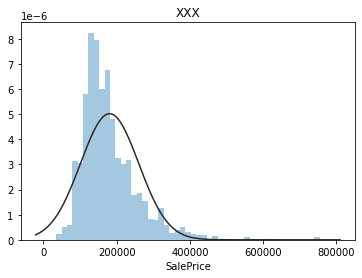

In [148]:
y = datasets['1.original']["SalePrice"]
plt.figure(1); plt.title('XXX')
sns.distplot(y, kde=False, fit=stats.norm)

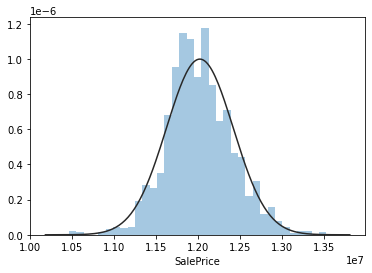

In [163]:
log_y = round(np.log1p(datasets['1.original']["SalePrice"])*1e6).astype(int)
sns.distplot(log_y,kde=False,fit=stats.norm)

In [0]:
def inverse_transform(data_transformed):
  try:
    return round(data_transformed.apply(lambda x: math.exp(x/1e6)-1)).astype(int)
  except:
    return (np.exp(data_transformed/1e6)-1).round().astype(int)

In [167]:
data = datasets['2.cleaned + new variables']
numeric_features = []
for i in data:
  if data[i].dtype != object:
    numeric_features.append(i)
numeric_features = [i for i in numeric_features if i not in ['Id','SalePrice']]
numeric_features[0:10]


['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'CentralAir']

In [168]:
skew_features = data[numeric_features].apply(lambda x: skew(x))#.sort_values(ascending=False)
skew_features.head()

LotFrontage     0.022013
LotArea        12.822431
OverallQual     0.197110
OverallCond     0.570312
MasVnrArea      2.613592
dtype: float64

In [169]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))

An input array is constant; the correlation coefficent is not defined.
An input array is nearly constant; the computed correlation coefficent may be inaccurate.


In [170]:
datasets.keys()

dict_keys(['1.original', '0.0_test_original', '2.cleaned + new variables'])

In [171]:
final_features = pd.get_dummies(data).reset_index(drop=True)

#Delete previous 'SalePrice' column
#final_features.drop('SalePrice',axis=1,inplace=True)

datasets['5.all_features_log_transform'] = pd.concat([log_y,final_features],axis=1).reset_index(drop=True)
datasets['5.all_features_log_transform'].SalePrice

0       12247699.0
1       12109016.0
2       12317171.0
3       11849405.0
4       12429220.0
           ...    
2914           NaN
2915           NaN
2916           NaN
2917           NaN
2918           NaN
Name: SalePrice, Length: 2919, dtype: float64

### Train Models


In [0]:
#data = datasets['5.all_features_log_transform']
#x_train,x_test,y_train,y_test = train_test_split(data.drop(['SalePrice','Id'],axis=1),data['SalePrice'], test_size=0.2,random_state=42)


In [0]:
def train_models(x_train,x_test,y_train,y_test):
    tree = DecisionTreeRegressor(max_depth=5,min_weight_fraction_leaf=0.03,random_state=42)
    rf = RandomForestRegressor(n_estimators = 50, random_state = 42, bootstrap=True
                               #,max_samples=0.5
                               ,min_weight_fraction_leaf=0.01
                              )
    xgboost = XGBRegressor(n_estimators=100,early_stopping_rounds=5,eval_set=[(x_test, y_test)])
    mod_list = {'lin_reg':LinearRegression(),'svm':svm.SVR(kernel='linear'),'tree':tree,'random_forest':rf,'xgboost':xgboost}
    perf_metrics = ['R^2','MAE','RMSE','MAPE','RMSLE']
    results = pd.DataFrame(columns=perf_metrics)

    for i in mod_list:
        #Train models
        mod_list[i].fit(x_train,y_train)
        y_pred = mod_list[i].predict(x_test)
        #Transform y_test and y_pred to original values if needed
        y_test2 = inverse_transform(y_test)
        y_pred2 = inverse_transform(y_pred)
        r2 = mod_list[i].score(x_test, y_test)
        mae = metrics.mean_absolute_error(y_pred2,y_test2)
        rmse = np.sqrt(metrics.mean_squared_error(y_pred2,y_test2))
        mape = mean_absolute_percentage_error(y_test2,y_pred2)
        rmsle = ''
        try:
            rmsle = np.sqrt(metrics.mean_squared_log_error(y_test2,y_pred2))
        except:
            pass
        line = pd.DataFrame(data=[[r2,mae,rmse,mape,rmsle]],index=[i],columns=results.columns)
        results = pd.concat([results,line],axis=0)
    
    return results,mod_list

In [0]:
# results,mod_list = train_models(x_train,x_test,y_train,y_test)
# results

In [0]:
# # Plot Decision Tree
# model = mod_list['random_forest'].estimators_[2]
# model.get_depth()
# plt.figure(figsize=(120,50))
# a = plot_tree(model, 
#               feature_names=x_train.columns, 
#               #class_names=breast_cancer.target_names, 
#               filled=True, 
#               rounded=True, 
#               fontsize=40)

In [0]:
# # Cross Validation
# X = datasets['4.selected variables'].drop(['SalePrice','Id'],axis=1)                                         
# y = datasets['4.selected variables']['SalePrice']
# metric = 'neg_mean_squared_log_error'
# print('Cross Validation: \n',metric,':')
# np.mean(np.sqrt(np.absolute(cross_val_score(mod_list['random_forest'],X, y, cv=5, scoring=metric))))

In [172]:
datasets.keys()

dict_keys(['1.original', '0.0_test_original', '2.cleaned + new variables', '5.all_features_log_transform'])

### Submission File

In [174]:
y = datasets['1.original']['SalePrice']
x_train = final_features.iloc[:len(y),:]
y_train = log_y
x_test = final_features.iloc[len(y):,:]
xgboost = XGBRegressor(n_estimators=100,early_stopping_rounds=5)
xgboost.fit(x_train,y_train)

[20:55:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [185]:
submission = pd.read_csv('https://raw.githubusercontent.com/tgrasty/house_prices/master/sample_submission.csv')
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [189]:
submission.iloc[:,1] = inverse_transform(xgboost.predict(x_test))
submission.set_index(submission['Id'],inplace=True)
submission.drop('Id',axis=1,inplace=True)
submission.head()

,SalePrice
Id,
1461,126068
1462,168256
1463,175957
1464,187687
1465,202937


In [190]:
submission.shape

(1459, 1)

In [0]:
from google.colab import files
submission.to_csv('house_prices-submission.csv')
files.download('house_prices-submission.csv')

### Feature Importance

In [0]:
#Random Forest Score
# Keep in mind that this importance score is biased because it favors high cardinality features
importances = pd.DataFrame(mod_list['random_forest'].feature_importances_,columns=['score'])
pd.concat([pd.DataFrame(x_train.columns,columns=['features']),importances],axis=1).sort_values('score',ascending=False)

In [0]:
# Recursive feature elimination
estimator = mod_list['random_forest']
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(x_train, y_train)

In [0]:
#Careful! notice that RFE provides a Ranking not a Score, which means the LOWEST value represents the best feature
rfe_importances = pd.DataFrame(selector.ranking_,columns=['score'])
pd.concat([pd.DataFrame(x_train.columns,columns=['features']),rfe_importances],axis=1).sort_values('score',ascending=True)

In [0]:
#Permutation Importance
model = mod_list['random_forest']
result = permutation_importance(model, x_test, y_test, n_repeats=10,random_state=42,scoring='neg_mean_squared_log_error')

In [0]:
#Careful! notice that Permutation Importance provides a Score, which means the HIGHEST value represents the best feature
perm_importances = pd.DataFrame(result.importances_mean,columns=['score'])
perm_importances = perm_importances['score'].apply(lambda x: '%.10f' % x)
df_perm_imiportances = pd.concat([pd.DataFrame(x_train.columns,columns=['features']),perm_importances],axis=1).sort_values('score',ascending=False)
df_perm_imiportances

In [0]:
#Select features for next training cycle
feature_selection2 = df_perm_imiportances.iloc[0:10,0]
feature_selection2

#### Global Interpretability

In [0]:
model = mod_list['random_forest']
shap_values = shap.TreeExplainer(model).shap_values(x_train)
shap.summary_plot(shap_values, x_train)

In [0]:
shap.dependence_plot('OverallQual', shap_values, x_train)

#### Local Interpretability

In [0]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [0]:
x_output = x_test.copy()
x_output.loc[:,'predict'] = np.round(model.predict(x_output),2)
S = x_output.head()
S

In [0]:
shap_plot(0)

In [0]:
pd.DataFrame(shap_values,columns=x_train.columns).head()

## Modeling 2

### Explore Errors 

In [0]:
explore_errors = {}
for i in mod_list:
    y_pred = inverse_transform(mod_list[i].predict(x_test))
    y_test = inverse_transform(y_test)
    ranges = pd.cut(y_test.reset_index(drop=True),20)
    explore_errors[i] = pd.concat([y_test.reset_index(drop=True),ranges,pd.DataFrame(y_pred)],axis=1)
    explore_errors[i].columns = ['y_test','y_test_range','y_pred']

In [0]:
i = 'random_forest'
test = pd.concat([x_test.reset_index(drop=True),explore_errors[i]],axis=1)
test['error'] = test['y_pred']-test['y_test']

In [0]:
table = test.groupby('y_test_range').agg({'error':'mean','y_pred':'count'})
table['%'] = table['y_pred']/table['y_pred'].sum()*100
table['%cum_sum'] = table['%'].cumsum()
table.columns = ['error_mean','count(y_pred)','%','%cum_sum']
table.head()

In [0]:
table['y_test_range'] = table.index

In [0]:
cross_plot(table,'%','error_mean','y_test_range',order=0,titulo='Errores Modelo')

In [0]:
table